In [0]:
import numpy as np
%tensorflow_version 2.x
import tensorflow as tf
from tensorflow import keras
import matplotlib.pyplot as plt
from keras import backend as K


In [47]:
#two channels, do k-bit, M-ary generalisation. starting with k=4 for 16 symbols
n = 2
k = 4
M = 2**k
R = k/n
channel_noise_dB=13
channel_noise_ratio = 10**(channel_noise_dB/10)
PD_noise_dB=13
PD_noise_ratio = 10**(PD_noise_dB/10)
CD_noise_dB=13
CD_noise_ratio = 10**(CD_noise_dB/10)
noise_mag1 = np.sqrt(1/(2*R*channel_noise_ratio))
PDnoise_mag = 1/(2*R*PD_noise_ratio)
CDnoise_mag = np.sqrt(1/(2*R*CD_noise_ratio))
print(noise_mag1)
print(PDnoise_mag)

0.11193605692841697
0.012529680840681807


In [48]:
dat_size=M*10000
rand_data=np.random.randint(M,size=dat_size)
xs = keras.utils.to_categorical(rand_data)
print('verification checks:')
print(xs[2],'\n',xs[20],'\n',xs[200])

verification checks:
[0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0.] 
 [0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.] 
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0.]


In [0]:
#Custom layer definition
class EnergySplitter(keras.layers.Layer):
  '''
  Creates two copies of the input, concatenated onto one dimension, each 
  multiplied by a constant. The parameter rho is trainable.
  The first copy of the input is multiplied by (1-rho), while the second is
  multiplied by rho.
  '''
  def compute_output_shape(self,input_shape):
    return [input_shape,input_shape]
  
  def __init__(self,**kwargs):
    super(EnergySplitter,self).__init__(**kwargs)
    #initialise the splitting ratio
    self.rho=tf.Variable(
        initial_value=0.8,
        trainable=True,
        constraint=lambda t: tf.clip_by_value(t,0,1)
    )

  def call(self,inputs):
    return [K.sqrt(1-self.rho)*inputs,K.sqrt(self.rho)*inputs]

class SquareSum(keras.layers.Layer):
  '''
  returns a scalar value, the sum of the elementwise squared input
  '''
  def compute_output_shape(self, input_shape):
    return (None,1)
  
  def __init__(self, **kwargs):
    super(SquareSum,self).__init__(**kwargs)
  
  def call(self, inputs):
    return K.reshape(tf.convert_to_tensor([K.sum(K.square(inputs),axis=1)],dtype='float32'),shape=(tf.shape(inputs)[0],1))


class RectMod16(keras.layers.Layer):
  '''
  takes a 1-hot class vector as an input, outputs the corresponding rectangular 
  16-QAM baseband values, using keras operations
  '''
  def compute_output_shape(self,input_shape):
    return (input_shape[0],2)
  
  def __init__(self, **kwargs):
    super(RectMod16,self).__init__(**kwargs)
    self.coords_tensor=coords_tensor = tf.cast(tf.convert_to_tensor(
        [(3,3),(1,3),(3,1),(1,1),(-3,3),(-1,3),(-3,1),(-1,1),(3,-3),(1,-3),(3,-1),(1,-1),(-3,-3),(-1,-3),(-3,-1),(-1,-1)]
        ),dtype=tf.float32)

  def call(self,inputs):
    return tf.tensordot(inputs,self.coords_tensor,axes=1)
    #multiply by coords tensor

In [50]:
#Build the model:

#input
autoenc_in = keras.layers.Input(shape=(M,),name='Information_Input')

#encoder
encoder = RectMod16(name='Modulator')(autoenc_in)

#Regulariser
regulariser = keras.layers.BatchNormalization(center=False,scale=False,name='Regulariser')(encoder)

#Channel noise
channel = keras.layers.GaussianNoise(noise_mag1,name='Channel_Noise')(regulariser)

#Splitter
splitter_layer = EnergySplitter(name='Splitter')
splitter = splitter_layer(channel)

#PD processing
presquaring = SquareSum()(splitter[0])
PD_noise = keras.layers.GaussianNoise(PDnoise_mag,name='PD_Noise')(presquaring)

#CD processing
CD_noise = keras.layers.GaussianNoise(CDnoise_mag,name='CD_Noise')(splitter[1])

#Try adding pre-processing to do something with each pathway before merging
PD_preproc = keras.layers.Dense(M,activation='relu',name='PD_Preprocessing')(PD_noise)
CD_preproc = keras.layers.Dense(M,activation='relu',name='CD_Preprocessing')(CD_noise)

#Merge two inputs
Merge = keras.layers.Concatenate(axis=-1,name='Merge')([PD_preproc,CD_preproc])

#decoder
decoder_0 = keras.layers.Dense(M,activation='relu',name='Decoder_Processing')(Merge)
#decoder_ins= keras.layers.Dense(M,activation='relu')(decoder_0)
decoder_1 = keras.layers.Dense(M,activation='softmax',name='Decoder_Output')(decoder_0)

#Put it together
autoencoder = keras.models.Model(autoenc_in,decoder_1)
print(autoencoder.summary())


Model: "model_9"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
Information_Input (InputLayer)  [(None, 16)]         0                                            
__________________________________________________________________________________________________
Modulator (RectMod16)           (None, 2)            0           Information_Input[0][0]          
__________________________________________________________________________________________________
Regulariser (BatchNormalization (None, 2)            4           Modulator[0][0]                  
__________________________________________________________________________________________________
Channel_Noise (GaussianNoise)   (None, 2)            0           Regulariser[0][0]                
____________________________________________________________________________________________

In [0]:
#keras.utils.plot_model(
#    autoencoder,
#    to_file='modelmap.png'
#)

In [0]:
adam = keras.optimizers.Adam(learning_rate=0.001)
autoencoder.compile(optimizer=adam, loss='categorical_crossentropy')

In [53]:
autoencoder.fit(xs,xs,batch_size=M*100,epochs=30)
autoencoder.fit(xs,xs,batch_size=M*100,epochs=30)
autoencoder.fit(xs,xs,batch_size=M*100,epochs=30)

Epoch 1/30
100/100 [==============================] - 0s 3ms/step - loss: 2.6307
Epoch 2/30
100/100 [==============================] - 0s 3ms/step - loss: 1.8371
Epoch 3/30
100/100 [==============================] - 0s 3ms/step - loss: 0.9242
Epoch 4/30
100/100 [==============================] - 0s 3ms/step - loss: 0.3988
Epoch 5/30
100/100 [==============================] - 0s 3ms/step - loss: 0.1948
Epoch 6/30
100/100 [==============================] - 0s 3ms/step - loss: 0.1182
Epoch 7/30
100/100 [==============================] - 0s 3ms/step - loss: 0.0839
Epoch 8/30
100/100 [==============================] - 0s 3ms/step - loss: 0.0657
Epoch 9/30
100/100 [==============================] - 0s 3ms/step - loss: 0.0541
Epoch 10/30
100/100 [==============================] - 0s 3ms/step - loss: 0.0463
Epoch 11/30
100/100 [==============================] - 0s 3ms/step - loss: 0.0402
Epoch 12/30
100/100 [==============================] - 0s 3ms/step - loss: 0.0373
Epoch 13/30
100/100 [====

In [0]:
#Make subordinate models for plotting/simulation
encoder = keras.models.Model(autoenc_in,regulariser)

#Make the decoder from the concatenation onwards: 
#deco_in = [keras.layers.Input(shape=(1,)),keras.layers.Input(shape=(2,))]
deco_PD_in = keras.layers.Input(shape=(1,))
deco_CD_in = keras.layers.Input(shape=(2,))
deco_PD = autoencoder.layers[-5](deco_PD_in)
deco_CD = autoencoder.layers[-4](deco_CD_in)
deco = autoencoder.layers[-3]([deco_PD,deco_CD])
deco = autoencoder.layers[-2](deco)
deco = autoencoder.layers[-1](deco)
decoder = keras.models.Model([deco_PD_in,deco_CD_in],deco)

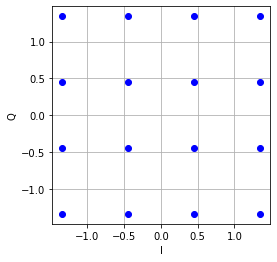

rho = 0.8924817
PD proportion = 0.3278998556194354
CD proportion = 0.94471246


In [55]:
#Plot modulation scheme
data = []
for i in range(0,M):
  temp = np.zeros(M)
  temp[i] = 1
  data.append(encoder.predict(np.expand_dims(temp,axis=0)))
data = np.array(data)
data = data.reshape(M,2,1)
plt.plot(data[:,0],data[:,1],'bo')
plt.grid()
plt.xlabel('I')
plt.ylabel('Q')
plt.axis('square')
plt.show()
rho=splitter_layer.get_weights()[0]
print('rho =',rho)
print('PD proportion =',np.sqrt(1-rho))
print('CD proportion =',np.sqrt(rho))

In [56]:
#Calculate expected power usage (for equal usage of each symbol)
power_use=0
for iter1 in np.arange(M):
    symbol_energy=data[iter1,0,0]**2+data[iter1,1,0]**2
    power_use += symbol_energy/M
print(power_use)
scaling=np.sqrt(power_use/n)
print('scaling, should be around 1, =',scaling)

2.0022278203435637
scaling, should be around 1, = 1.0005568000727305


In [57]:
'''
# Monte-Carlo Modelling
rho=splitter_layer.get_weights()[0]
# Three ebno amounts, which can vary separately. Express as a list even if a 
# single value. In practice, only make longer than 1, fix the other two for plotting
EbNo_range_dB_channel = list(np.arange(0,16,1.5))
EbNo_range_dB_PD = list([10*np.log10(PD_noise_ratio)])
EbNo_range_dB_CD = list([10*np.log10(CD_noise_ratio)])
ser = [None]*(len(EbNo_range_dB_channel)*len(EbNo_range_dB_PD)*len(EbNo_range_dB_CD))
for iter1 in range(len(EbNo_range_dB_channel)):
  for iter2 in range(len(EbNo_range_dB_PD)):
    for iter3 in range(len(EbNo_range_dB_CD)):
      # Create channel noise vector
      EbNo_channel = 10**(EbNo_range_dB_channel[iter1]/10)
      noise_std_channel = np.sqrt(1/(2*R*EbNo_channel))*scaling
      noise_channel = noise_std_channel*np.random.randn(dat_size,n)
      # Create PD noise vector
      EbNo_PD = 10**(EbNo_range_dB_PD[iter2]/10)
      noise_std_PD = np.sqrt(1/(2*R*EbNo_PD))*scaling
      noise_PD = noise_std_PD*np.random.randn(dat_size)
      # Create CD noise vector
      EbNo_CD = 10**(EbNo_range_dB_CD[iter3]/10)
      noise_std_CD = np.sqrt(1/(2*R*EbNo_CD))*scaling
      noise_CD = noise_std_CD*np.random.randn(dat_size,n)
      # Get encoder output and add channel noise
      channel_out=encoder.predict(xs)+noise_channel
      # PD section
      PD_input = channel_out*np.sqrt(1-rho)
      PD_squared = np.array([PD_input[i][0]*PD_input[i][0]+PD_input[i][1]*PD_input[i][1] for i in range(len(PD_input))])
      PD_out = PD_squared+noise_PD
      # CD section, literally just add more noise to scaled input
      CD_out = channel_out*np.sqrt(rho)+noise_CD
      # Prediction based on noises
      prediction = decoder.predict([PD_out,CD_out])
      prediction = np.argmax(prediction,axis=1)
      wrong = (prediction != rand_data)
      count=np.sum(wrong)
      index=iter3+len(EbNo_range_dB_CD)*iter2+len(EbNo_range_dB_CD)*len(EbNo_range_dB_PD)*iter1
      ser[index]=count/dat_size
      print('Channel EbNo(dB):',EbNo_range_dB_channel[iter1],'| PD EbNo(dB):',EbNo_range_dB_PD[iter2],'| CD EbNo(dB):',EbNo_range_dB_CD[iter3],'| SER',ser[index])
'''

"\n# Monte-Carlo Modelling\nrho=splitter_layer.get_weights()[0]\n# Three ebno amounts, which can vary separately. Express as a list even if a \n# single value. In practice, only make longer than 1, fix the other two for plotting\nEbNo_range_dB_channel = list(np.arange(0,16,1.5))\nEbNo_range_dB_PD = list([10*np.log10(PD_noise_ratio)])\nEbNo_range_dB_CD = list([10*np.log10(CD_noise_ratio)])\nser = [None]*(len(EbNo_range_dB_channel)*len(EbNo_range_dB_PD)*len(EbNo_range_dB_CD))\nfor iter1 in range(len(EbNo_range_dB_channel)):\n  for iter2 in range(len(EbNo_range_dB_PD)):\n    for iter3 in range(len(EbNo_range_dB_CD)):\n      # Create channel noise vector\n      EbNo_channel = 10**(EbNo_range_dB_channel[iter1]/10)\n      noise_std_channel = np.sqrt(1/(2*R*EbNo_channel))*scaling\n      noise_channel = noise_std_channel*np.random.randn(dat_size,n)\n      # Create PD noise vector\n      EbNo_PD = 10**(EbNo_range_dB_PD[iter2]/10)\n      noise_std_PD = np.sqrt(1/(2*R*EbNo_PD))*scaling\n      noi

In [0]:
dat_size=M*10000
rand_data=np.random.randint(M,size=dat_size)
xs = keras.utils.to_categorical(rand_data)

In [59]:
# Monte-Carlo Modelling for processing noise consistent relative to channel noise
rho=splitter_layer.get_weights()[0]
# Three ebno amounts, which can vary separately. Express as a list even if a 
# single value. In practice, only make longer than 1, fix the other two for plotting
EbNo_range_dB_channel = list(np.arange(0,16,1.5))
EbNo_dB_PD_diff = PD_noise_dB - channel_noise_dB
EbNo_dB_CD_diff = CD_noise_dB - channel_noise_dB
ser = [None]*len(EbNo_range_dB_channel)
for iter1 in range(len(EbNo_range_dB_channel)):
  # Create channel noise vector
  EbNo_channel_dB=EbNo_range_dB_channel[iter1]
  EbNo_channel = 10**(EbNo_channel_dB/10)
  noise_std_channel = np.sqrt(1/(2*R*EbNo_channel))*scaling
  noise_channel = noise_std_channel*np.random.randn(dat_size,n)
  # Create PD noise vector
  EbNo_PD = 10**((EbNo_dB_PD_diff+EbNo_channel_dB)/10)
  noise_std_PD = 1/(2*R*EbNo_PD)*scaling
  noise_PD = noise_std_PD*np.random.randn(dat_size)
  # Create CD noise vector
  EbNo_CD = 10**((EbNo_dB_CD_diff+EbNo_channel_dB)/10)
  noise_std_CD = np.sqrt(1/(2*R*EbNo_CD))*scaling
  noise_CD = noise_std_CD*np.random.randn(dat_size,n)
  # Get encoder output and add channel noise
  channel_out=encoder.predict(xs)+noise_channel
  # PD section
  PD_input = channel_out*np.sqrt(1-rho)
  PD_squared = np.array([PD_input[i][0]*PD_input[i][0]+PD_input[i][1]*PD_input[i][1] for i in range(len(PD_input))])
  PD_out = PD_squared+noise_PD
  # CD section, literally just add more noise to scaled input
  CD_out = channel_out*np.sqrt(rho)+noise_CD
  # Prediction based on noises
  prediction = decoder.predict([PD_out,CD_out])
  prediction = np.argmax(prediction,axis=1)
  wrong = (prediction != rand_data)
  count=np.sum(wrong)
  ser[iter1]=count/dat_size
  print('Channel EbNo(dB):',EbNo_range_dB_channel[iter1],'| PD EbNo(dB):',EbNo_dB_PD_diff+EbNo_channel_dB,'| CD EbNo(dB):',EbNo_dB_CD_diff+EbNo_channel_dB,'| SER',ser[iter1])

Channel EbNo(dB): 0.0 | PD EbNo(dB): 0.0 | CD EbNo(dB): 0.0 | SER 0.67810625
Channel EbNo(dB): 1.5 | PD EbNo(dB): 1.5 | CD EbNo(dB): 1.5 | SER 0.59989375
Channel EbNo(dB): 3.0 | PD EbNo(dB): 3.0 | CD EbNo(dB): 3.0 | SER 0.505775
Channel EbNo(dB): 4.5 | PD EbNo(dB): 4.5 | CD EbNo(dB): 4.5 | SER 0.3952875
Channel EbNo(dB): 6.0 | PD EbNo(dB): 6.0 | CD EbNo(dB): 6.0 | SER 0.28058125
Channel EbNo(dB): 7.5 | PD EbNo(dB): 7.5 | CD EbNo(dB): 7.5 | SER 0.17274375
Channel EbNo(dB): 9.0 | PD EbNo(dB): 9.0 | CD EbNo(dB): 9.0 | SER 0.0901625
Channel EbNo(dB): 10.5 | PD EbNo(dB): 10.5 | CD EbNo(dB): 10.5 | SER 0.038225
Channel EbNo(dB): 12.0 | PD EbNo(dB): 12.0 | CD EbNo(dB): 12.0 | SER 0.012325
Channel EbNo(dB): 13.5 | PD EbNo(dB): 13.5 | CD EbNo(dB): 13.5 | SER 0.00229375
Channel EbNo(dB): 15.0 | PD EbNo(dB): 15.0 | CD EbNo(dB): 15.0 | SER 0.00031875


In [60]:
# sandbox
print(ser)
print(rho)

[0.67810625, 0.59989375, 0.505775, 0.3952875, 0.28058125, 0.17274375, 0.0901625, 0.038225, 0.012325, 0.00229375, 0.00031875]
0.8924817
